### Setup environment ###

Here we import all necessary modules for our model including our own python modules.

In [1]:
import os
import glob
import torch
import numpy as np

from datetime import datetime
from tqdm import tqdm
from torch import nn, optim
from sklearn.metrics import classification_report

# Import own python files
from datasets import InMemoryDataset, SubmissionDataset
from pre_processing import create_normalizer_for_dataset
from model import Net
from visualisations import visualize_bands, plot_confusion_matrix, visualize_losses_during_training
from utils import create_submission


# init deterministic seed
seed_value = 1234
np.random.seed(seed_value)  # set numpy seed
torch.manual_seed(seed_value)  # set pytorch seed CPU

## Define directory paths ##

We define the directories in which models are stored, the raw data can be found and the submission data is stored.

In [2]:
MODELS_PATH = "models"
DATA_PATH = "ds/images/remote_sensing/otherDatasets/sentinel_2/tif"
SUBMISSION_DATA_PATH = "testset"

## Data Loading ##

For the data loading we use a custom torch dataset which loads data into memory. We also integrate normalization (mean 0, std 1) into the data loading.

In [3]:
# Get a list of all available files for training
samples = glob.glob(os.path.join(DATA_PATH, "*", "*.tif"))
print(len(samples))

# Load data into custom torch data set
dataset = InMemoryDataset(samples)
# Uncomment to create normalizer from scratch
# dataset = InMemoryDataset(samples, lambda x:x)
# normalizer = create_normalizer_for_dataset(dataset, verbose=True)
# del dataset
# dataset = InMemoryDataset(samples, normalizer)

27000


Loading training samples: 100%|███████████| 27000/27000 [04:37<00:00, 97.46it/s]


### Split Training Data ###

In order to visualize both validation as well as training loss during training we split the data available for training. This not done when we run the notebook for submission since we want to use as much data for training in that case as possible.

In [4]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [20000,7000])
print(f"length of dataset: {len(dataset)}")
print(f"length of train set: {len(train_dataset)}")
print(f"length of test set: {len(test_dataset)}")

batch_size = 128
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
)

length of dataset: 27000
length of train set: 20000
length of test set: 7000


In [5]:
# Check shape of sample
next(iter(train_dataloader))[0].shape

torch.Size([128, 12, 64, 64])

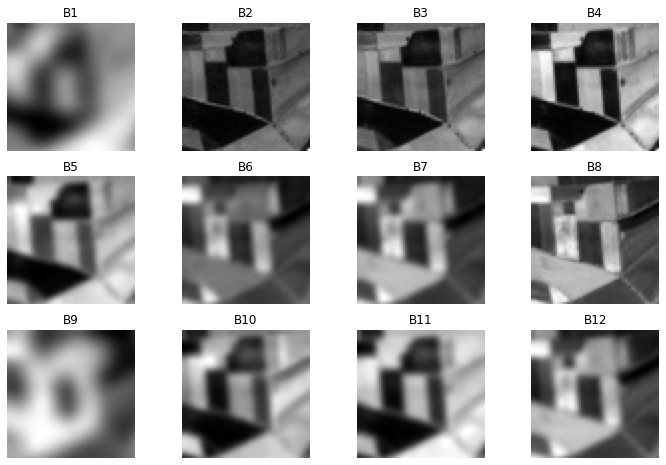

In [6]:
# Visualize bands of a training sample
visualize_bands(train_dataset[212][0].numpy())

## Define Model ##

In this section we load the model that we defined in our own "model.py" module.

In [7]:
net = Net()
# selected_model_path = "new_model_20.pth"
# net = Net()
# net.load_state_dict(torch.load(os.path.join(MODELS_PATH, selected_model_path)))

num_params = 0
for param in net.parameters():
    num_params += param.numel()

print("Number of to be trained model parameters: {}.".format(num_params))

Number of to be trained model parameters: 6345886.


## Train Model ##

In this section we train our model with a cross-entropy loss utilizing stochasting gradiednt descent.

In [8]:
# Define optimization
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [11]:
train_epoch_losses = []
validation_epoch_losses = []

epochs = 5
for epoch in range(epochs):  # loop over the dataset multiple times

    # init collection of mini-batch losses
    train_mini_batch_losses = []
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dataloader, 0):

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())
            
    # Per epoch store the training... 
    train_epoch_loss = np.mean(train_mini_batch_losses)
    train_epoch_losses.append(train_epoch_loss)
    # ...and validation loss, ...
    with torch.no_grad():
        validation_mini_batch_losses = []
        for (images, labels) in test_dataloader:
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            validation_epoch_loss = criterion(outputs, labels)
            # collect mini-batch reconstruction loss
            validation_mini_batch_losses.append(loss.data.item())
        validation_epoch_loss = np.mean(validation_mini_batch_losses)
        validation_epoch_losses.append(validation_epoch_loss)
    # ...print statistics, ...
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print(f"[LOG {now}] epoch: {epoch+1} train-loss: {train_epoch_loss} validation-loss: {validation_epoch_loss}")
    # ...and save the model every 10 epochs
    if (epoch) % 10 == 0 and epoch != 0:
        if not os.path.exists(MODELS_PATH):
            os.mkdir(MODELS_PATH)
        print("Saving model")
        torch.save(
            net.state_dict(), os.path.join(MODELS_PATH, f"new_model_all_samples_{epoch}.pth")
        )
print("Finished Training")

[LOG 20220521-15:29:06] epoch: 1 train-loss: 0.7517356299290991 validation-loss: 0.6902434229850769
[LOG 20220521-15:31:17] epoch: 2 train-loss: 0.6035872722507283 validation-loss: 0.5763586759567261
[LOG 20220521-15:33:58] epoch: 3 train-loss: 0.46105257815616146 validation-loss: 0.4686715602874756
[LOG 20220521-15:36:19] epoch: 4 train-loss: 0.402316833852203 validation-loss: 0.30244210362434387
[LOG 20220521-15:38:28] epoch: 5 train-loss: 0.3500654901478701 validation-loss: 0.13754266500473022
Finished Training


### Evaluate model ###

We evaluate our model in three stages:
1. We plot the validation and training loss 
2. We calculate important classification metrics such as accuracy, precision and recall.
3. By plotting a confusion matrix we are able to look at the performance per class

Thereby we check for over- and underfitting, performance and performance per class.

This section only works if we created a test set.

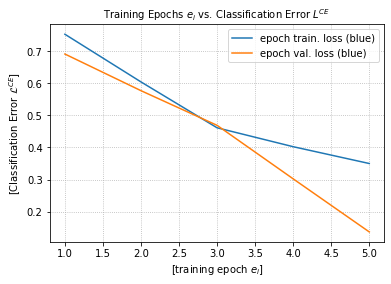

In [12]:
visualize_losses_during_training(train_epoch_losses, validation_epoch_losses)

In [13]:
y_pred = []
y_true = []
# iterate over test data
with torch.no_grad():
    for (images, labels) in tqdm(test_dataloader, desc="Predict labels"):
        outputs = net(images)  # Feed Network
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.numpy())  # Save Prediction
        y_true.extend(labels.numpy())  # Save Truth

Predict labels: 100%|███████████████████████████| 55/55 [00:16<00:00,  3.34it/s]


In [14]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       788
           1       0.98      0.96      0.97       796
           2       0.86      0.85      0.86       767
           3       0.66      0.73      0.69       648
           4       0.85      0.95      0.90       642
           5       0.88      0.86      0.87       517
           6       0.87      0.72      0.79       634
           7       0.92      0.82      0.87       811
           8       0.76      0.91      0.83       646
           9       1.00      0.83      0.91       751

    accuracy                           0.85      7000
   macro avg       0.86      0.85      0.85      7000
weighted avg       0.86      0.85      0.86      7000



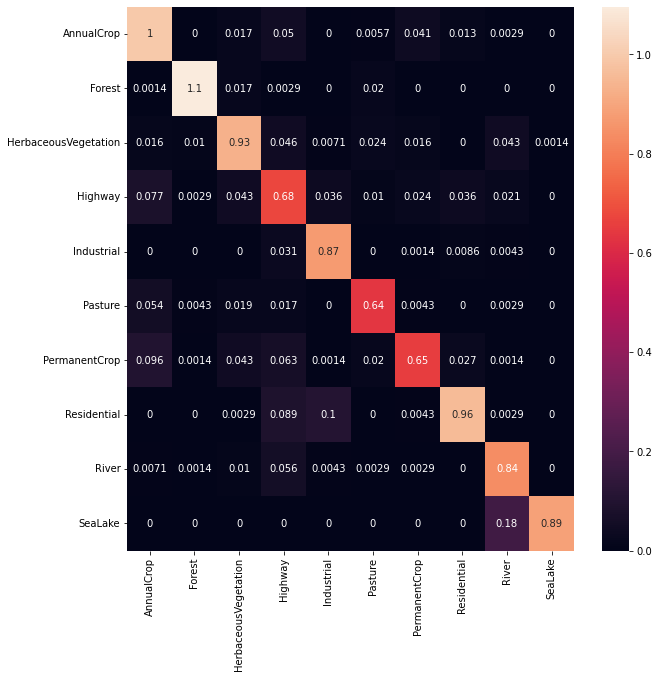

In [15]:
plot_confusion_matrix(y_true, y_pred)

## Create submission ##

#### Load Model

In [ ]:
!ls models

In [ ]:
# selected_model_path = "new_model_20.pth"
# net = Net()
# net.load_state_dict(torch.load(os.path.join(MODELS_PATH, selected_model_path), map_location=torch.device('cpu')))

#### Load submission data

In [ ]:
submission_testset_samples = glob.glob(os.path.join(SUBMISSION_DATA_PATH, "*.npy"))
submission_dataset = SubmissionDataset(submission_testset_samples)
# Uncomment to create normalizer from scratch
# submission_dataset = SubmissionDataset(submission_testset_samples,lambda x:x)
# sub_normalizer = create_normalizer_for_dataset(submission_dataset, verbose=True)
# del submission_dataset
# submission_dataset = SubmissionDataset(submission_testset_samples, sub_normalizer)

submission_dataloader = torch.utils.data.DataLoader(
    submission_dataset,
    batch_size=1,
    shuffle=False,
)

In [ ]:
visualize_bands(submission_dataset[212].numpy())

#### Create submission ####

In [ ]:
create_submission(net, submission_dataloader)

In [ ]:
import pandas as pd
df = pd.read_csv("submission.csv")
df["label"].value_counts()